Importando o necessario



In [ ]:
#Para Implementar a VGG16
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense
from tensorflow.keras import Model

#Para imprimir o modelo
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz

#Para aplicar o DA
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import skimage
from skimage import io
from skimage.io import imread
from skimage.transform import resize

from tensorflow.keras import layers

# Conectando com os dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Carregando os dados

In [ ]:
# carregue as imagens 

# inicializa matrizes X e y
X = np.empty([400, 112, 92]) # 40 classe com 10 imgs cada, 10304 = 112x92
y = np.empty([400, 1])

# percorre todos os diretorios da base att e carrega as imagens
imgs_path = "/content/drive/My Drive/data/att_faces"
i=0
class_id = 0
for f in os.listdir(imgs_path): 
    #print(f)
    if f.startswith("s"):
        class_id = class_id + 1
        for img_path in os.listdir(os.path.join(imgs_path,f)):
            if img_path.endswith(".pgm"):
                #print(img_path)
                X[i, :, :] = io.imread(os.path.join(imgs_path,f,img_path))
                y[i, :] = class_id        
                i = i + 1
 

print("dimensões da matriz X = " , X.shape)

dimensões da matriz X =  (400, 112, 92)


Sepando em dados de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [ ]:
X_train.shape

(280, 112, 92)

In [ ]:
X_test.shape

(120, 112, 92)

In [ ]:
X_train_new = np.expand_dims(X_train,3 )
X_test_new = np.expand_dims(X_test,3 )

X_train_new.shape

(280, 112, 92, 1)

In [ ]:
y_train_new = y_train.squeeze()
y_test_new = y_test.squeeze()

y_train_new = y_train_new - 1; 
y_test_new = y_test_new - 1;

y_test_new.shape

(120,)

# Definindo as tecnicas de DA

In [ ]:
#Aplicar DA

def apply_DA(case,images):

  
  data_augmentation = 0
  if case==1:
    #Espelha a imagem
    data_augmentation = tf.keras.Sequential([
      layers.RandomFlip(mode="horizontal"),
    ])

  if case==2:
    #Faz uma pequena rotação na imagem 
    data_augmentation = tf.keras.Sequential([
      layers.RandomRotation(factor=0.15),
    ])

  if case==3:
    #Faz um zoom in na imagem 
    data_augmentation = tf.keras.Sequential([
      layers.RandomZoom(height_factor=(-0.1,-0.2),width_factor=(-0.1,-0.2),fill_mode="constant",fill_value=0),
    ])
  if case==4:
    #Faz um Zoom out na imagem
    data_augmentation = tf.keras.Sequential([
      layers.RandomZoom(height_factor=(0.1,0.2),width_factor=(0.1,0.2),fill_mode="constant",fill_value=0),
    ])
  if case==5:
    #Faz um flip vertical
    data_augmentation = tf.keras.Sequential([
      layers.RandomFlip(mode="vertical"),
    ])
  
  resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(112, 92),
    layers.Rescaling(1./255)
    ])

  
  

  augmented_image = data_augmentation(images)

  augmented_image = resize_and_rescale(augmented_image)

  return augmented_image 

# Definição do Modelo

In [ ]:
input = Input(shape = (X.shape[1], X.shape[2],1))

# 1st Conv block

x = Conv2D (filters =32, kernel_size =3, padding ='same', activation='relu')(input)
#x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 2nd Conv block

x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
#x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 3rd Conv block

x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x) 
#x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
#x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 4th Conv block

x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
#x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
#x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 5th Conv block

x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
#x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
#x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# Fully connected layers  

x = Flatten()(x) 
#x = Dense(units = 4096, activation ='relu')(x) 
x = Dense(units = 512, activation ='relu')(x) 
#output = Dense(units = 1000, activation ='softmax')(x)
output = Dense(units = 40, activation ='softmax')(x)


# creating the model

model = Model (inputs=input, outputs =output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 92, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 112, 92, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 46, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 46, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 23, 128)       73856 

# Esquema do Modelo

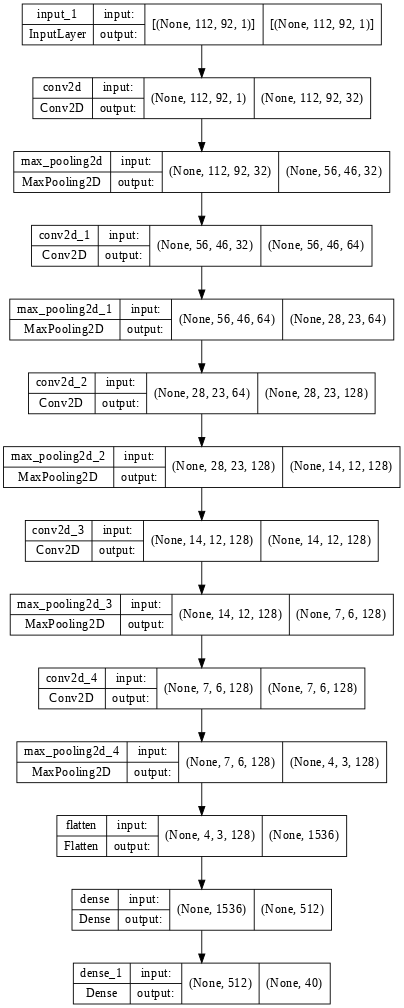

In [ ]:
#Para imprimir o modelo
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

# Compilando o Modelo

In [ ]:
model.compile( optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['acc'])

### Aplicando Metodo de DA

### Espelhamento

In [ ]:
trainsize= X_train_new.shape[0]
dataAug = X_train_new
apply=1

case = 1
dataAug=apply_DA(case,dataAug)

#dataAug=np.append(dataAug,X_train_new,axis=0)
#y_train_new=np.append(y_train_new,y_train_new,axis=0)

dataAug.shape

TensorShape([280, 112, 92, 1])

### Rotação

In [ ]:
trainsize= X_train_new.shape[0]
dataAug = X_train_new
apply=1

case = 2
dataAug=apply_DA(case,dataAug)

#dataAug=np.append(dataAug,X_train_new,axis=0)
#y_train_new=np.append(y_train_new,y_train_new,axis=0)


dataAug.shape

TensorShape([280, 112, 92, 1])

### Zoom in


In [ ]:
trainsize= X_train_new.shape[0]
dataAug = X_train_new
apply=1

case = 3
dataAug=apply_DA(case,dataAug)

#dataAug=np.append(dataAug,X_train_new,axis=0)
#y_train_new=np.append(y_train_new,y_train_new,axis=0)


dataAug.shape

TensorShape([280, 112, 92, 1])

### Zoom out

In [ ]:
trainsize= X_train_new.shape[0]
dataAug = X_train_new
apply=1

case = 4
dataAug=apply_DA(case,dataAug)

#dataAug=np.append(dataAug,X_train_new,axis=0)
#y_train_new=np.append(y_train_new,y_train_new,axis=0)


dataAug.shape

TensorShape([280, 112, 92, 1])

### Flip vertical

In [ ]:
trainsize= X_train_new.shape[0]
dataAug = X_train_new
apply=1

case = 5
dataAug=apply_DA(case,dataAug)

#dataAug=np.append(dataAug,X_train_new,axis=0)
#y_train_new=np.append(y_train_new,y_train_new,axis=0)


dataAug.shape

TensorShape([280, 112, 92, 1])

### Aplica dois metodos em sequencia

In [ ]:
#Zoom out + Rotação
#case1 = 4
#case2 = 2
#Zoom out + Rotação
#case1 = 3
#case2 = 2
#Espelhamento + Rotação
#case1 = 1
#case2 = 2
#FlipVertical + Rotação
case1 = 2
case2 = 1
#case3 = 2
#
#case1 = 4
#case2 = 2
#
#case1 = 4
#case2 = 2

In [ ]:
trainsize= X_train_new.shape[0]
dataAux1 = X_train_new
dataAux2 = X_train_new
apply=2

dataAux1=apply_DA(case1,dataAux1)

dataAux2=apply_DA(case2,dataAux2)

dataAug=np.append(dataAux1,dataAux2,axis=0)#Dados aumentados + originais
y_train_new=np.append(y_train_new,y_train_new,axis=0)

#dataAug=np.append(dataAug,dataAug,axis=0)#Dados aumentados + originais
#y_train_new=np.append(y_train_new,y_train_new,axis=0)

#dataAug=np.append(dataAug,dataAug,axis=0)#Dados aumentados + originais
#y_train_new=np.append(y_train_new,y_train_new,axis=0)


#dataAug=apply_DA(case2,dataAug)

#dataAug=np.append(dataAug,dataAug2,axis=0)#Dados aumentados + originais + dados aumentados
#y_train_new=np.append(y_train_new,y_train_new,axis=0)

#dataAug2=apply_DA(case3,dataAug)

#dataAug=np.append(dataAug,dataAug2,axis=0)#Dados aumentados + originais + dados aumentados + dados aumentados
#y_train_new=np.append(y_train_new,y_train_new,axis=0)


dataAug.shape

(560, 112, 92, 1)

In [ ]:
aux=X_train_new

dataAug=np.append(aux,aux,axis=0)
dataAug.shape

(560, 112, 92, 1)

### Entrada+Aumentada dados de treino

In [ ]:
trainsize1= X_train_new.shape[0]
aux1 = X_train_new
#apply=1

case1 = 5
aux2=apply_DA(case1,aux1)

#dataAug=np.append(dataAug,X_train_new,axis=0)
#y_train_new=np.append(y_train_new,y_train_new,axis=0)

aux2.shape

TensorShape([280, 112, 92, 1])

-----------------------------------------


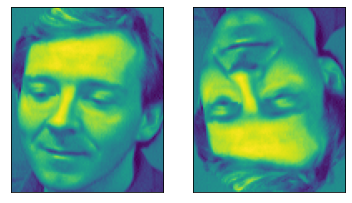

In [ ]:
#imprime as imagens para conferencia
#Imagem de Entrada|Aumentada do conjunto que sera treinado
img1 = aux1[40,:,:] 

img2 = aux2[40,:,:] 

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(np.squeeze(img1))
plt.xticks([]); plt.yticks([])
f.add_subplot(1,2, 2)
plt.imshow(np.squeeze(img2))
plt.xticks([]); plt.yticks([])
print("-----------------------------------------")

# Treinando o modelo

In [ ]:
history = model.fit(dataAug,y_train_new,validation_split=0.3,batch_size=20,epochs=20) # Todo ...

Epoch 1/20
20/20 [==============================] - 11s 564ms/step - loss: 3.3434 - acc: 0.2857 - val_loss: 2.1395 - val_acc: 0.4286
Epoch 2/20
20/20 [==============================] - 11s 561ms/step - loss: 1.6565 - acc: 0.5306 - val_loss: 1.1674 - val_acc: 0.6726
Epoch 3/20
20/20 [==============================] - 11s 564ms/step - loss: 0.8018 - acc: 0.7679 - val_loss: 0.8981 - val_acc: 0.8155
Epoch 4/20
20/20 [==============================] - 11s 567ms/step - loss: 0.4091 - acc: 0.8597 - val_loss: 1.3170 - val_acc: 0.7738
Epoch 5/20
20/20 [==============================] - 11s 569ms/step - loss: 0.2003 - acc: 0.9439 - val_loss: 1.1522 - val_acc: 0.8214
Epoch 6/20
20/20 [==============================] - 11s 561ms/step - loss: 0.0742 - acc: 0.9847 - val_loss: 0.9732 - val_acc: 0.8512
Epoch 7/20
20/20 [==============================] - 11s 562ms/step - loss: 0.0122 - acc: 1.0000 - val_loss: 1.2163 - val_acc: 0.8155
Epoch 8/20
20/20 [==============================] - 11s 560ms/step - 

In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

# Verifica a Acuracia do Modelo

4/4 - 1s - loss: 2182.4597 - acc: 0.3083 - 793ms/epoch - 198ms/step


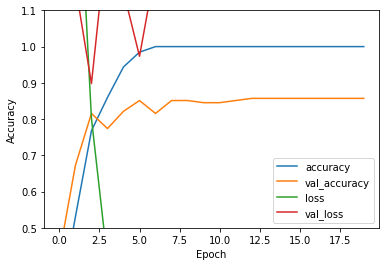

In [ ]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test_new,  y_test_new, verbose=2)

In [ ]:
print(test_acc)

0.3083333373069763


# Funçoes Auxiliares para comparar os rostos

In [ ]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [ ]:
epsilon = 0.0040

def verifyFace(img1, img2):
    
    img1_representation = model.predict(img1, steps=None)[0,:]
    img2_representation = model.predict(img2, steps=None)[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    print("Similaridade com distancia do cosseno: ",cosine_similarity)
    print("Similaridade com distancia euclideana: ",euclidean_distance)
    
    if(cosine_similarity < epsilon):
        print("Verificado! Mesma pessoa!")
    else:
        print("Não-verificado! Não são a mesma pessoa!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(np.squeeze(img1))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(np.squeeze(img2))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

# Verifica se dois rostos pertencem a mesma pessoa

Similaridade com distancia do cosseno:  0.0
Similaridade com distancia euclideana:  5.2800802e-05
Verificado! Mesma pessoa!


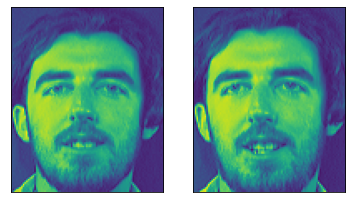

-----------------------------------------


In [ ]:


img1 = X[38,:,:] # Todo
img2 = X[31,:,:] # Todo

#img1 = X[25,:,:]/255 # Todo
#img2 = X[31,:,:]/255 # Todo


# lembre-se de expandir a primeira dimensão, pois nosso lote aqui é de 1 imagem
img1 = np.expand_dims(img1,0) # Todo ..
img2 = np.expand_dims(img2,0) # Todo ..
img1 = np.expand_dims(img1,3) # Todo ..
img2 = np.expand_dims(img2,3) # Todo ..

verifyFace(img1, img2)